In [5]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from minisom import MiniSom
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import psutil
import warnings
import tracemalloc

In [21]:
# Inizializzazione del dataset e dei parametri
DATA_PATH = "/users/mik2002/som/dataset-processed CIC-IDS-2018/"
FILES = ["processed_bot_dataset.csv", "processed_dos_dataset.csv","processed_Ddos_dataset.csv", "processed_bruteforce_dataset.csv"]
df_dataset = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES], ignore_index=True)

display(df_dataset["Label"].value_counts())
print("Distribution:")
display(df_dataset["Label"].value_counts(normalize=True))

Label
Benign        10194284
DDos            576191
Dos             507715
Bot             282310
Bruteforce      156668
Name: count, dtype: int64

Distribution:


Label
Benign        0.870030
DDos          0.049175
Dos           0.043331
Bot           0.024094
Bruteforce    0.013371
Name: proportion, dtype: float64

In [ ]:
sampled_df = df_dataset.groupby("Label").apply(lambda x: x.sample(frac=0.01, random_state=42))
sampled_df["Label"] = sampled_df["Label"].map({"Benign": 0, "Dos":1,"DDos":2 ,"Bot":3,"Bruteforce":4})

In [79]:
import pandas as pd

# Supponiamo che il tuo dataframe sia df_dataset
# Campionamento specifico per ciascuna classe
def custom_sample(df, label, frac, random_state):
    return df[df["Label"] == label].sample(frac=frac, random_state=random_state)

# Applica il campionamento
benign_sampled = custom_sample(df_dataset, "Benign", 0.0020, 42)  # 0.25% del totale per "Benign"
other_sampled = df_dataset[df_dataset["Label"] != "Benign"].groupby("Label").apply(lambda x: x.sample(frac=0.01, random_state=42))

# Concatenare i due campioni
sampled_df = pd.concat([benign_sampled, other_sampled])

# Resetta l'indice se necessario
sampled_df.reset_index(drop=True, inplace=True)

# Mappa le etichette
sampled_df["Label"] = sampled_df["Label"].map({"Benign": 0, "Dos": 1, "DDos": 2, "Bot": 3, "Bruteforce": 4})

/tmp/ipykernel_242871/128097869.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_sampled = df_dataset[df_dataset["Label"] != "Benign"].groupby("Label").apply(lambda x: x.sample(frac=0.01, random_state=42))


In [80]:
sampled_df["Label"].value_counts()

Label
0    20389
2     5762
1     5077
3     2823
4     1567
Name: count, dtype: int64

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(sampled_df.iloc[:, :-1])
target = sampled_df.iloc[:, -1].values

In [82]:
# split data in Training and Testing set
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.2)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing  set has {} samples.".format(X_test.shape[0]))

Training set has 28494 samples.
Testing  set has 7124 samples.


In [72]:
# set hyperparameters
n_neurons = 20
m_neurons = 20
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = 20000

In [85]:

from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)
som.random_weights_init(data)


In [22]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [86]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [ 20000 / 20000 ] 100% - 0:00:00 left 
 quantization error: 0.5775557724476041
CPU times: user 11 s, sys: 4.34 ms, total: 11 s
Wall time: 6.19 s


In [ ]:
som.topographic_error(X_test)


np.float64(0.04028635597978664)

In [ ]:
%%time
y_pred = classify(som, X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9916    0.9899    0.9907    203742
           1     0.9834    0.9450    0.9638     10339
           2     0.9643    0.9757    0.9700     11417
           3     0.7607    0.9291    0.8365      5683
           5     0.9226    0.7382    0.8202      3163

    accuracy                         0.9823    234344
   macro avg     0.9245    0.9156    0.9162    234344
weighted avg     0.9834    0.9823    0.9825    234344

CPU times: user 1min 51s, sys: 78 ms, total: 1min 51s
Wall time: 1min 51s


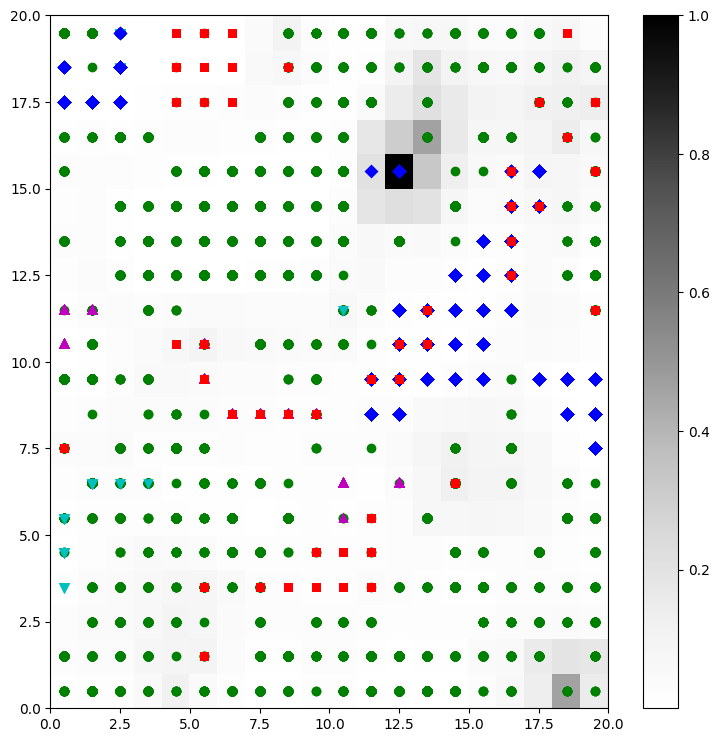

CPU times: user 35.9 s, sys: 360 ms, total: 36.3 s
Wall time: 36.3 s


In [88]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

# Utilizzo della mappa dei colori 'Greys' per uno sfondo chiaro
plt.pcolor(som.distance_map().T, cmap='Greys')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
labels = ['Benign', 'DDos', 'Dos', 'Bot', 'Bruteforce']
markers = {
    'Benign': 'o',        # Circle
    'DDos': 's',          # Square
    'Dos': 'D',           # Diamond
    'Bot': 'v',           # Down triangle
    'Bruteforce': '^'     # Up triangle
}
colors = {
    'Benign': 'g',        # Green for benign
    'DDos': 'r',          # Red for DDos
    'Dos': 'b',           # Blue for Dos
    'Bot': 'c',           # Cyan for Bot
    'Bruteforce': 'm'     # Magenta for Bruteforce
}

for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    label = target[cnt]  # get the label for this data point
    # place a marker on the winning position for the sample xx
    plt.plot(w[0] + 0.5, w[1] + 0.5, 
             markers[labels[label]],  # select the marker based on the label
             markerfacecolor=colors[labels[label]],  # fill color of the marker
             markeredgecolor=colors[labels[label]],  # edge color of the marker
             markersize=5,  # size of the marker
             markeredgewidth=2)  # width of the edge

plt.show()